In [199]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

In [200]:
# Параметры системы
l1, l2 = 1.0, 1.0
m1, m2 = 1.0, 1.0
g = 9.8
Kv = 100*np.eye(2)
F = 10*np.eye(10)
A1, A2 = 0.25, 0.25
omega = 1.0
theta1, theta2 = 0.0, 0.0
Lambda = np.diag([0.2, 0.2])
kappa = 10

In [201]:
def M(q):
    return np.array([[
            (m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*np.cos(q[1]),
            m2*l2**2 + m2*l1*l2*np.cos(q[1])
        ], [
            m2*l2**2 + m2*l1*l2*np.cos(q[1]),
            m2*l2**2
        ]])

In [202]:
def Vm(q, dq):
    return np.array([[
            -dq[1]*m2*l1*l2*np.sin(q[1]),
            -(dq[0] + dq[1])*m2*l1*l2*np.sin(q[1])
        ], [
            dq[0]*m2*l1*l2*np.sin(q[1]),
            0
        ]])

In [203]:
# Целевые значения для углов
q1_target = lambda t: np.pi/2
q2_target = lambda t: A2*np.sin(omega*t + theta2)

In [204]:
def phi(x):
    return np.tanh(x)

In [205]:
def f(x):
    return np.array([np.sin(x[0]), np.cos(x[1])])

In [206]:
def equations(t, y):
    q_dot = y[:2]
    q = y[2:4]
    W = y[4:].reshape(-1, 2)
    
    q1_dot = 0
    q2_dot = A2*omega*np.cos(omega*t + theta2)
    
    q1_dot_dot = 0
    q2_dot_dot = -A2*(omega**2)*np.sin(omega*t + theta2)
    
    qd = np.array([q1_target(t), q2_target(t)])
    qd_dot = np.array([q1_dot, q2_dot])
    qd_dot_dot = np.array([q1_dot_dot, q2_dot_dot])
    
    # Ошибки
    e = q - qd
    e_dot = q_dot - qd_dot
    
    x = np.concatenate((e, e_dot, qd, qd_dot, qd_dot_dot))
    
    phi_x = phi(x)
    f_x = np.zeros(2)
    
    r = e_dot + Lambda @ e
    
    # Управляющий сигнал
    tau = W.T @ phi_x + Kv @ r
    tau_d = np.random.normal(0, 1, tau.size)
    r_dot = np.linalg.solve(M(q), -Vm(q, q_dot) @ r + f_x - tau + tau_d)
    
    W_dot = F @ np.outer(phi_x, r) - kappa*np.linalg.norm(r)*F @ W
    
    return np.concatenate((r_dot, q_dot, W_dot.ravel()))

In [207]:
# Начальные условия
q0 = np.zeros(2)
q_dot0 = np.zeros(2)
W0 = np.zeros((10, 2))
init = np.concatenate((q_dot0, q0, W0.ravel()))
t_span = [0, 50]
t_eval = np.linspace(0, 50, 100)

<IPython.core.display.Javascript object>


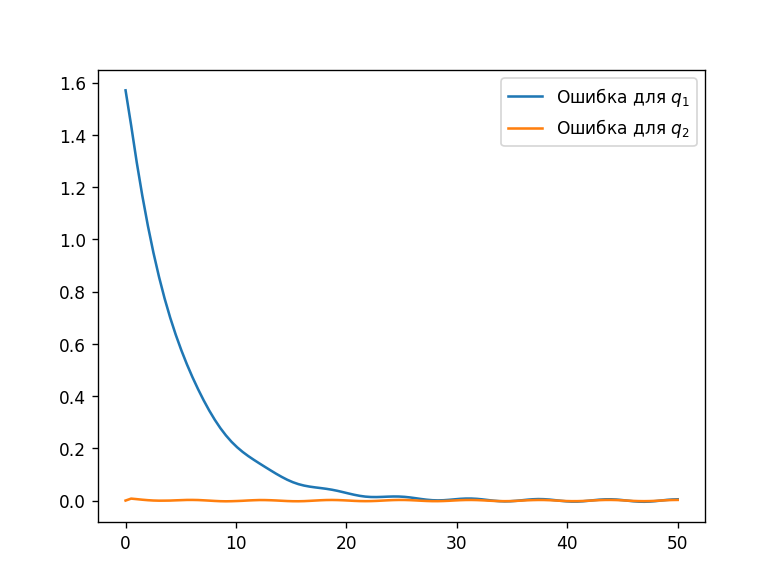

In [208]:
# Решение системы
sol = solve_ivp(equations, t_span, init, t_eval=t_eval, method='RK23')

q1_sol = sol.y[2, :]
q2_sol = sol.y[3, :]

# Вычисление ошибок для q1 и q2
error_q1 = q1_target(t_eval) - q1_sol
error_q2 = q2_target(t_eval) - q2_sol

fig, ax = plt.subplots()
ax.plot(t_eval, error_q1, label='Ошибка для $q_1$')
ax.plot(t_eval, error_q2, label='Ошибка для $q_2$')
ax.legend(loc='best')
plt.show()

In [209]:
def show_animation(sol, interval=50):
    q1 = sol[0, :]
    q2 = sol[1, :]

    ball1 = l1*np.array([np.sin(q1), -np.cos(q1)]).T
    ball2 = np.array([
        l1*np.sin(q1) + l2*np.sin(q1 + q2), 
        -l1*np.cos(q1) - l2*np.cos(q1 + q2)
    ]).T

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lim = l1 + l2 + 0.1
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))

    scat = ax.scatter(ball1[1, 0], ball1[1, 1])
    line2 = ax.plot([0, ball1[0, 0]], [0, ball1[0, 1]])[0]

    def update(frame):
        # for each frame, update the data stored on each artist.
        x1 = ball1[frame, 0]
        y1 = ball1[frame, 1]
        x2 = ball2[frame, 0]
        y2 = ball2[frame, 1]
        # update the scatter plot:
        data = np.stack([[x1, x2], [y1, y2]]).T
        line2.set_data([0, ball1[frame, 0], ball2[frame, 0]], [0, ball1[frame, 1], ball2[frame, 1]])
        scat.set_offsets(data)
        return scat

    anim = animation.FuncAnimation(fig=fig, func=update, frames=t_eval.shape[0], interval=interval)
    return anim

<IPython.core.display.Javascript object>


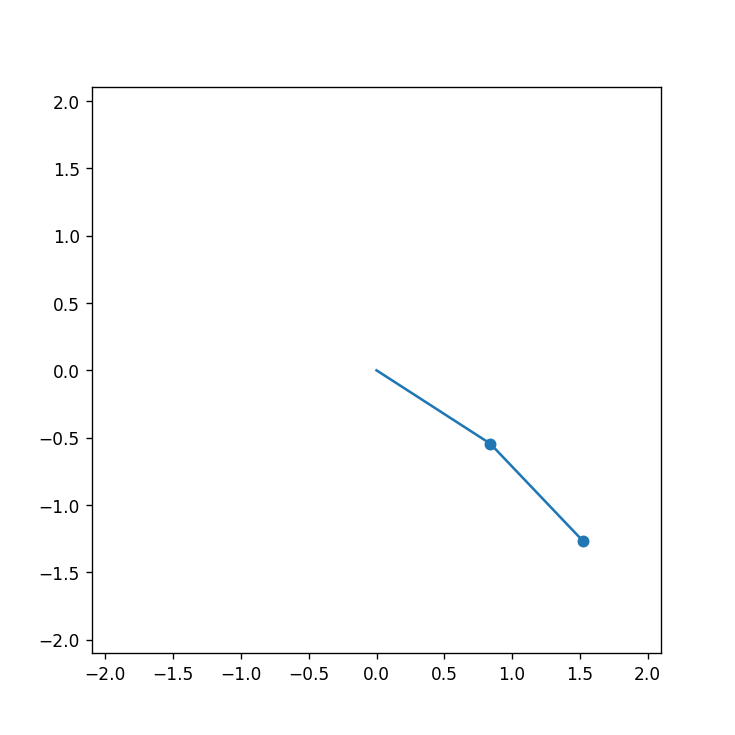

In [210]:
show_animation(np.vstack((q1_sol, q2_sol)))